In [8]:
import os
import re
import numpy as np            
import pandas as pd           
import scanpy as sc
import bbknn
import matplotlib.pyplot as plt
sc.set_figure_params(dpi=100, color_map='viridis', fontsize=6)
sc.settings.verbosity=2
sc.settings.n_jobs=16
sc.logging.print_versions()

stype = "CD4"
oDir = os.path.abspath("./OUT_Fig3")

if not os.path.exists(oDir):
    os.makedirs(oDir)
os.chdir(oDir)

-----
anndata     0.7.5
scanpy      1.6.1
sinfo       0.3.1
-----
PIL                 8.1.0
anndata             0.7.5
annoy               NA
backcall            0.1.0
bbknn               NA
cffi                1.12.3
colorama            0.4.1
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.0
decorator           4.4.0
future_fstrings     NA
get_version         2.1
google              NA
h5py                2.10.0
igraph              0.7.1
importlib_metadata  0.17
ipykernel           5.1.1
ipython_genutils    0.2.0
ipywidgets          7.6.3
jedi                0.13.3
joblib              0.13.2
kiwisolver          1.1.0
legacy_api_wrap     1.2
leidenalg           0.7.0
llvmlite            0.35.0
louvain             0.6.1
matplotlib          3.4.1
mpl_toolkits        NA
natsort             6.0.0
numba               0.52.0
numexpr             2.6.9
numpy               1.19.5
packaging           19.0
pandas              1.1.5
parso               0.4.0
pexpect       

In [9]:
adata = sc.read(f"{oDir}/../../data/expression/{stype}/integration/{stype}.expr.txt.gz", delimiter="\t",first_column_names=True)

Only considering the two last: ['.txt', '.gz'].
Only considering the two last: ['.txt', '.gz'].


In [10]:
## add cellInfo
cellInfo = pd.read_csv(f"{oDir}/../../data/metaInfo/{stype}.miniInfo.txt.gz", compression="gzip", sep="\t", header=0, index_col=0)
cellInfo = cellInfo.loc[list(adata.obs_names), [not bool(re.match('RNA_', i)) for i in cellInfo.columns] ]
adata.obs = cellInfo
#
adata.obs['cancerType'] = [re.sub('\\..*', '', i) for i in np.array(adata.obs.dataset)]

In [11]:
## subset
keep_clus = ['CD4.c16.Tfh.CXCR5','CD4.c17.TfhTh1.CXCL13']
flag = [i in keep_clus for i in adata.obs.loc[:,'meta.cluster']]
adata = adata[flag,]

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)


/data2/qss/01.software/miniconda3/lib/python3.7/site-packages/scanpy/preprocessing/_highly_variable_genes.py:208: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)
Trying to set attribute `.uns` of view, copying.


computing PCA
    on highly variable genes
    with n_comps=30
    finished (0:00:00)


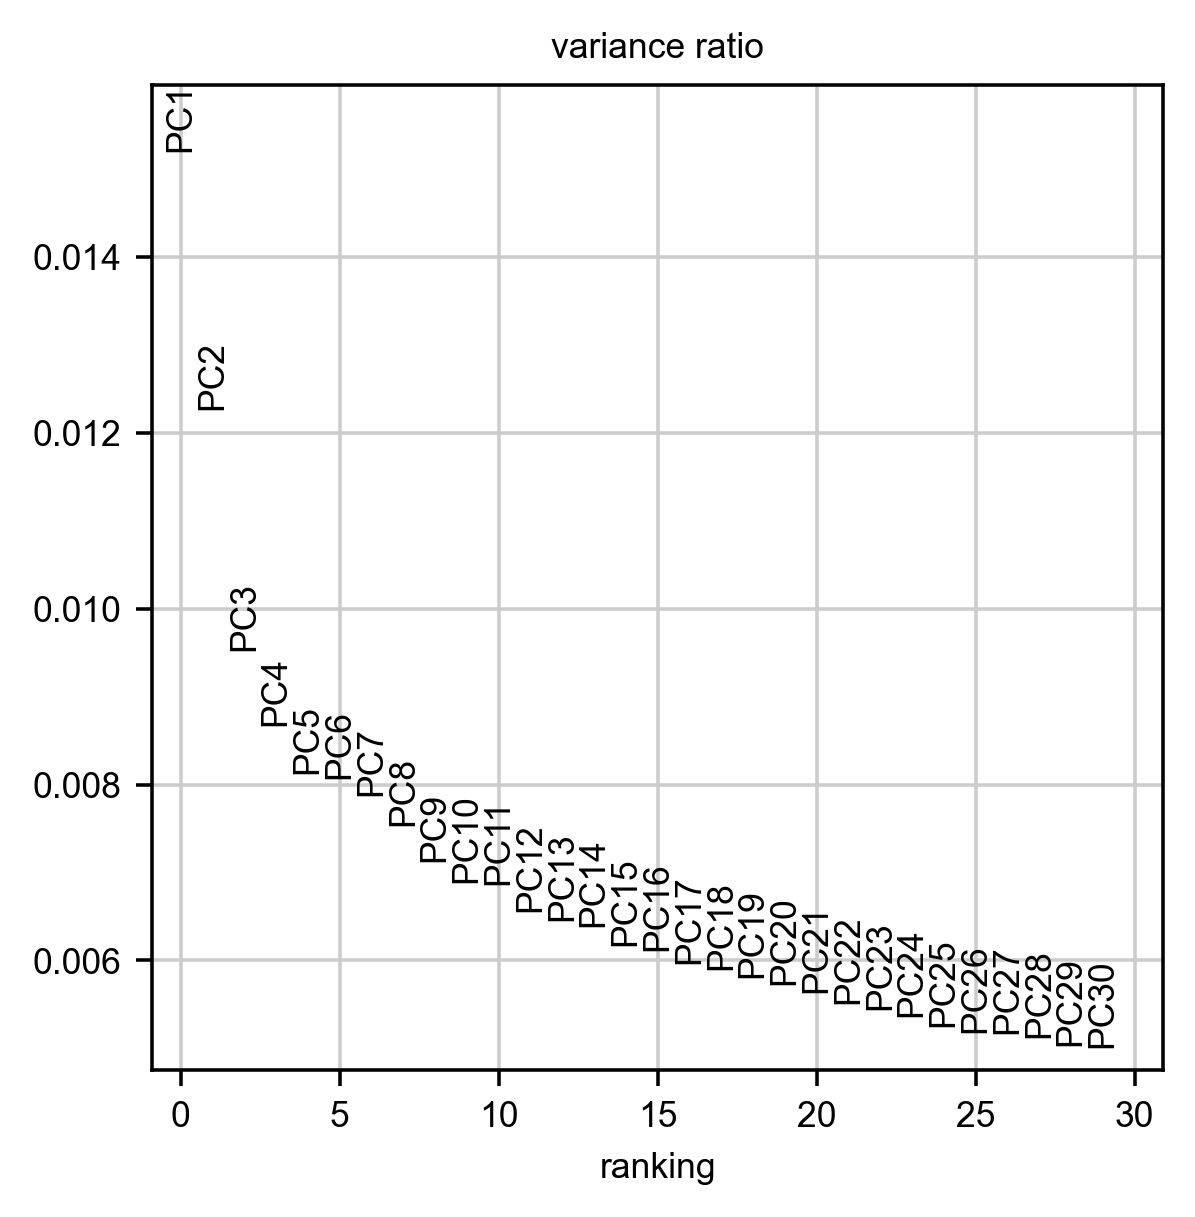

In [12]:
## hvg
sc.pp.highly_variable_genes(adata, n_top_genes=1000, subset=False)

## pca
sc.tl.pca(adata, n_comps=30)
sc.pl.pca_variance_ratio(adata)

# Run

In [13]:
sc.pp.neighbors(adata, n_pcs=15)

computing neighbors
    using 'X_pca' with n_pcs = 15
    finished (0:00:00)


In [14]:
## diffusion map
sc.tl.diffmap(adata, n_comps=10)

computing Diffusion Maps using n_comps=10(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.9372583  0.91606694 0.9011235  0.8683273  0.8349298
     0.8201014  0.79166067 0.78654087 0.7791856 ]
    finished (0:00:00)


... storing 'dataset' as categorical
... storing 'dataset.tech' as categorical
... storing 'ClusterID.pca' as categorical
... storing 'ClusterID.harmony' as categorical
... storing 'meta.cluster' as categorical
... storing 'meta.cluster.coarse' as categorical
... storing 'cancerType' as categorical


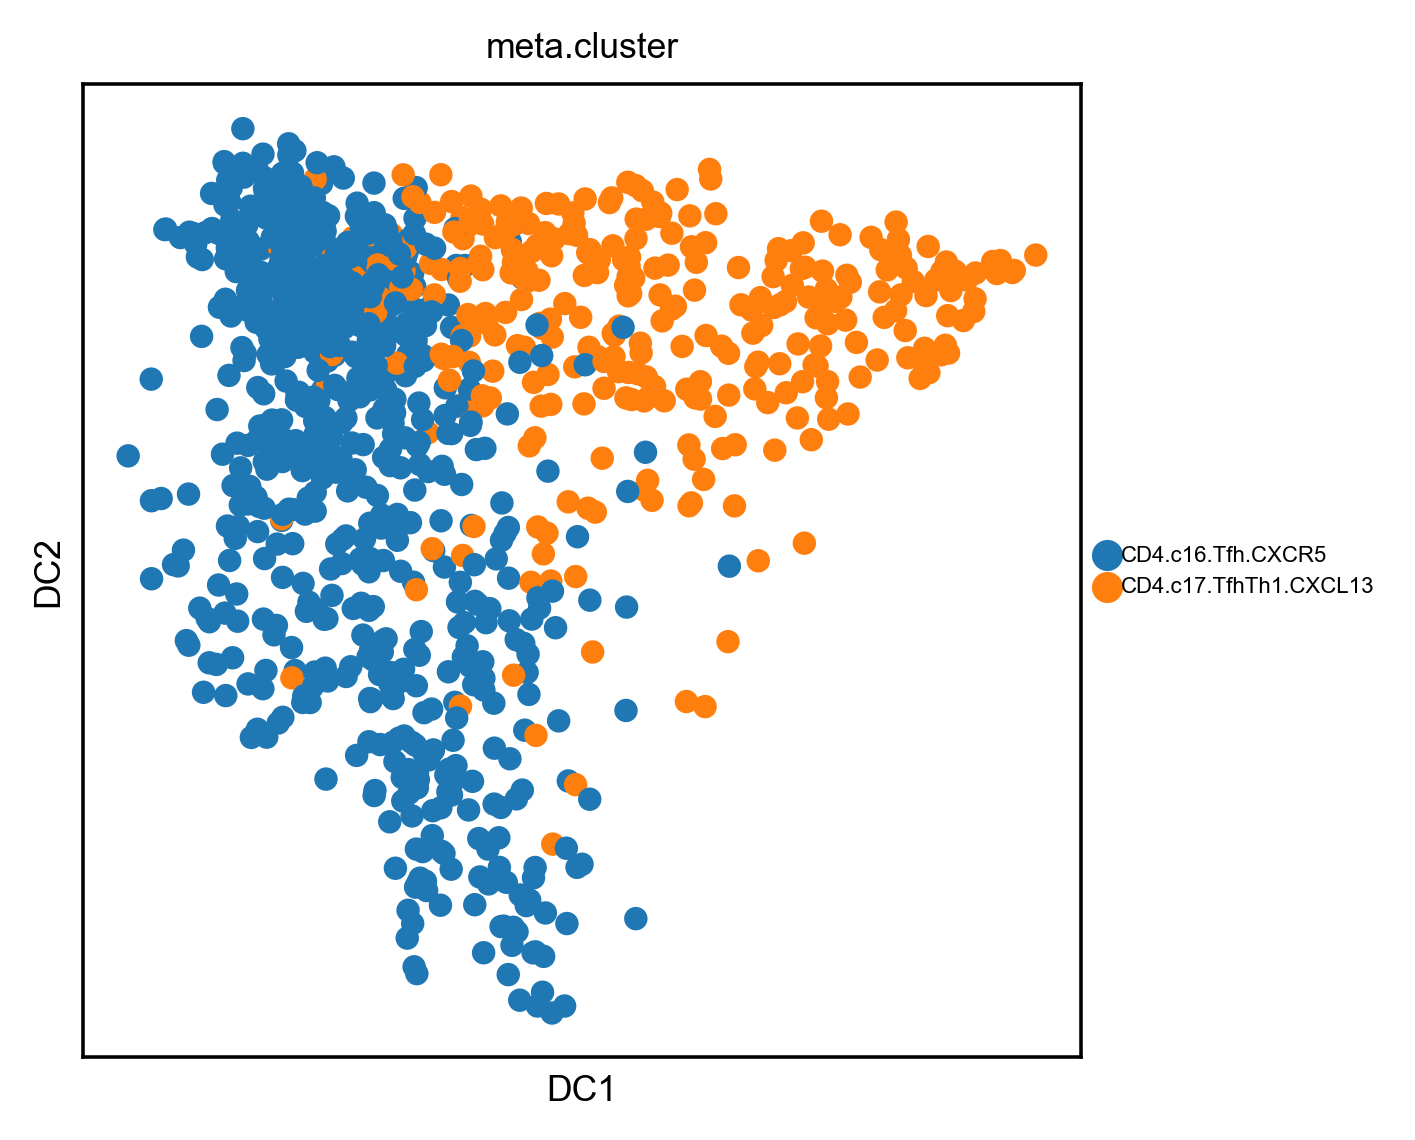

In [15]:
sc.set_figure_params(dpi=160, color_map='viridis', fontsize=8)
sc.pl.embedding(adata, basis='diffmap', color=['meta.cluster'],
                legend_loc='right margin', legend_fontsize=5,
                save=f".{stype}_Tfh.pdf")

In [16]:
## DPT
#Find the stem cell with the highest DC1 value to act as root for the diffusion pseudotime and compute DPT
Tn_mask = np.isin(adata.obs['meta.cluster'], ['CD4.c16.Tfh.CXCR5'])
min_stem_id = np.argmin(adata.obsm['X_diffmap'][Tn_mask, 1])
root_id = np.arange(len(Tn_mask))[Tn_mask][min_stem_id]
adata.uns['iroot'] = root_id
#
sc.tl.dpt(adata)

computing Diffusion Pseudotime using n_dcs=10
    finished (0:00:00)


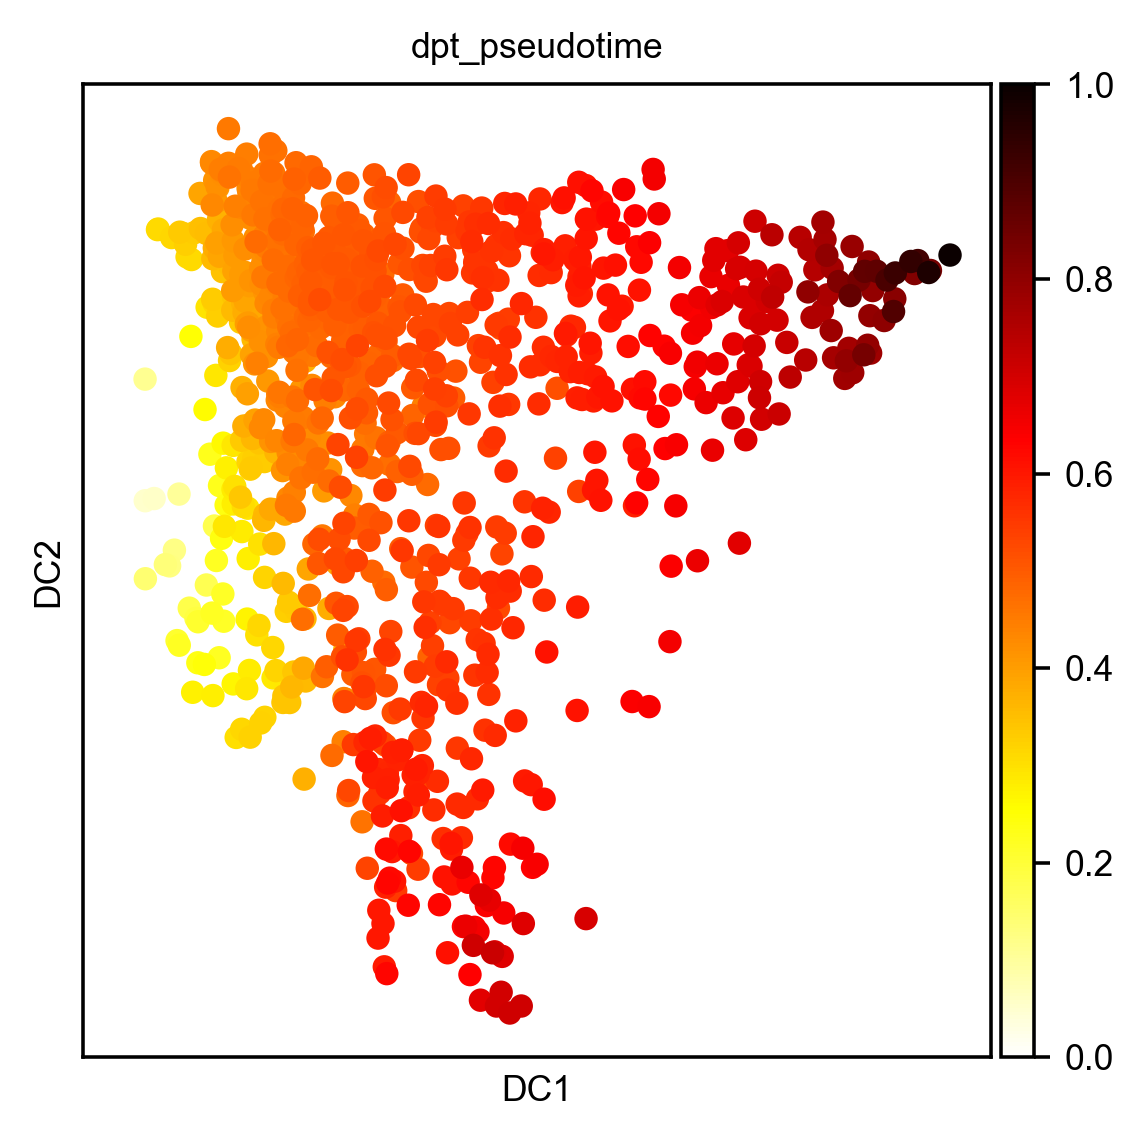

In [17]:
sc.pl.diffmap(adata, color='dpt_pseudotime', color_map="hot_r", save=f"_pseudotime.{stype}_Tfh.pdf")

In [18]:
## save
adata.write(f"{oDir}/{stype}_Tfh.sc.h5ad")
diff = pd.DataFrame(adata.obsm['X_diffmap'], index=adata.obs_names)
diff.to_csv(f"{oDir}/{stype}_Tfh.diffMap.txt", sep="\t")
adata.obs.loc[:,["meta.cluster","dpt_pseudotime"]].to_csv(f"{oDir}/{stype}_Tfh.dpt_pseudotime.txt", sep="\t")